# Pretraining on WikiText103

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_12a import *

## Data

In [3]:
#path = datasets.Config().data_path()
#version = '103' #2

In [4]:
#! wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-{version}-v1.zip -P {path}
#! unzip -q -n {path}/wikitext-{version}-v1.zip  -d {path}
#! mv {path}/wikitext-{version}/wiki.train.tokens {path}/wikitext-{version}/train.txt
#! mv {path}/wikitext-{version}/wiki.valid.tokens {path}/wikitext-{version}/valid.txt
#! mv {path}/wikitext-{version}/wiki.test.tokens {path}/wikitext-{version}/test.txt

WT103 comes in one big text file. If we want to shuffle at the beginning of each epoch, we have to cut it into different chunks.

In [5]:
path = datasets.Config().data_path()/'wikitext-103'

In [6]:
def istitle(line):
    return len(re.findall(r'^ = [^=]* = $', line)) != 0

In [7]:
def read_wiki(filename):
    articles = []
    with open(filename, encoding='utf8') as f:
        lines = f.readlines()
    current_article = ''
    for i,line in enumerate(lines):
        current_article += line
        if i < len(lines)-2 and lines[i+1] == ' \n' and istitle(lines[i+2]):
            current_article = current_article.replace('<unk>', UNK)
            articles.append(current_article)
            current_article = ''
    current_article = current_article.replace('<unk>', UNK)
    articles.append(current_article)
    return articles

In [8]:
train = TextList(read_wiki(path/'train.txt'), path=path)
valid = TextList(read_wiki(path/'valid.txt'), path=path)

In [9]:
len(train), len(valid)

(28476, 60)

In [10]:
sd = SplitData(train, valid)

In [11]:
proc_tok, proc_num = TokenizeProcessor(), NumericalizeProcessor()

The `lambda x: 0` means that all x get a 0 label.

In [12]:
ll = label_by_func(sd, lambda x: 0, proc_x = [proc_tok, proc_num])

In [13]:
pickle.dump(ll, open(path/'ld.pkl', 'wb'))

In [14]:
ll = pickle.load(open(path/'ld.pkl', 'rb'))

In [15]:
bs, bptt = 64, 70
data = lm_databunchify(ll, bs, bptt)

In [16]:
vocab = ll.train.proc_x[-1].vocab

In [17]:
len(vocab)

60001

## Model

In [18]:
dps = np.array([0.1, 0.15, 0.25, 0.02, 0.2]) * 0.2

In [19]:
tok_pad = vocab.index(PAD)

In [20]:
tok_pad

1

In [21]:
emb_sz, nh, nl = 300, 300, 2

In [22]:
model = get_language_model(len(vocab), emb_sz, nh, nl, tok_pad, *dps)

In [23]:
cbs = [
    partial(AvgStatsCallback, accuracy_flat),
    CudaCallback, Recorder,
    partial(GradientClipping, clip=0.1),
    partial(RNNTrainer, alpha=2., beta=1.),
    ProgressCallback
]

In [24]:
learn = Learner(model, data, cross_entropy_flat, lr=5e-3, cb_funcs=cbs, opt_func=adam_opt())

In [25]:
lr = 5e-3

In [26]:
sched_cos??

In [27]:
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [28]:
sched_lr  = combine_scheds([0.3,0.7], cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.8, 0.7, 0.8))

In [29]:
ll = np.arange(0, 1, .01)

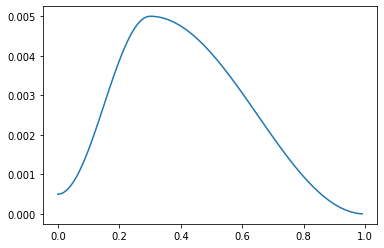

In [30]:
plt.plot(ll, [sched_lr(l) for l in ll])

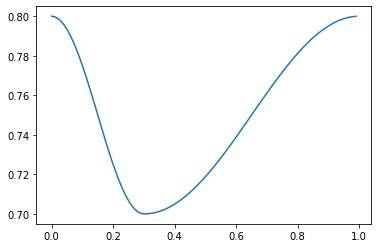

In [31]:
plt.plot(ll, [sched_mom(l) for l in ll])

In [32]:
cbsched = [ParamScheduler('lr', sched_lr), ParamScheduler('mom', sched_mom)]

In [33]:
learn.fit(10, cbs=cbsched)

epoch,train_loss,train_accuracy_flat,valid_loss,valid_accuracy_flat,time
0,4.439218,0.306704,3.998362,0.331198,1:02:02
1,3.752303,0.350324,3.842037,0.337739,1:02:03
2,3.657787,0.354181,3.814185,0.337970,1:02:02
3,3.632217,0.354375,3.802450,0.338114,1:02:05
4,3.608440,0.355571,3.767759,0.342474,1:02:04
5,3.577907,0.357907,3.719089,0.345775,1:02:14
6,3.542016,0.361015,3.664967,0.352156,1:02:11
7,3.509602,0.363934,3.618785,0.356676,1:02:13
8,3.488218,0.365830,3.584097,0.360296,1:02:11
9,3.478733,0.366659,3.577550,0.361428,1:02:15


In [34]:
torch.save(learn.model.state_dict(), path/'pretrained.pth')
pickle.dump(vocab, open(path/'vocab.pkl', 'wb'))